# Prosject 1 TMA4212

In [23]:
%matplotlib inline
from google.colab import files
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

# Task 1


In [7]:
# Setting the constants
sigma2 = 2
r = 1
c = 1

### Initial Conditions

In [20]:
def European_put(x):
    K = 1
    return np.maximum(K*np.ones(x.size)-x,np.zeros(x.size)) 

def butterfly_spread(x):
    K = 1
    H = 1
    f1 = np.maximum( x - K*np.ones(x.size) , np.zeros(x.size))  
    f2 = - 2 * np.maximum( x - (K+H)*np.ones(x.size) , np.zeros(x.size)) 
    f3 = np.maximum( x - (K+2*H)*np.ones(x.size) , np.zeros(x.size)) 
    return f1+f2+f3

def binary_call(x):
    K = 1
    return np.heaviside(x-K*np.ones(x.size), 1)

f = lambda x,t: 0

## Finite Difference Schemes for Black-Scholes by Forward Euler, Backward Euler and Crank-Nicholson

In [9]:
def matrix_A(P):
    # Returns the tridiagonal matrix which we use to contruct the matrices for
    # FE, BE, and CN. Returns a matrix of dimension P.

    # Making the matrix
    m = np.arange(1, P+1)        # array [1,2,...,P] 
    e = np.ones(P)               # array [1,1,...,1] 
    v = (sigma2/2)*m[1:]*m[1:]-(r/2)*m[1:] # lower diag
    d = sigma2*m*m+c*e # -diag
    w = (sigma2/2)*m[:P-1]*m[:P-1]+(r/2)*m[:P-1] # upper diag
    A = np.diag(v,-1)-np.diag(d)+np.diag(w,1)
    return A


In [10]:
def forward_euler(g, f=f, M=10, N=100, T=0.5, R=5, Neumann = False):
    # Solve the BS equation
    # with boundary conditions u(0,t)=u(0,0)e^{-ct}
    # and u(R,t) = u(R,0) if Dirichlet, 
    # and u_x(R,t) = 0 if Neumann,
    # with initial values u(x,0)=g(x)
    # over the time interval from 0 to T
    # and space interval 0 to R ("infinity").
    # Input: 
    #       g: function with the initial values,
    #       f: RHS, function of (space,time)
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of time integration
    #       R: considered infinity in x-direction
    #       Neumann: if infinity BC is Neumann
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values      

    if Neumann:
      P = M
    else:
      P = M - 1  

    b = np.zeros(P)            # Boundaries  
    fn = np.zeros(P)            # RHS 
      
    C = np.identity(P)+k*matrix_A(P)

    U[0, :] = g(x[0])*np.exp(-c*t)

    if Neumann:
      C[-1,-2] = k*sigma2*(M**2) 
      # Main loop 
      for n in range(N):
        b[0] = g(x[0])*np.exp(-c*n*k)*(sigma2-r)/2
        fn = f(x[1:],n*k) + b
        U[1:, n+1] = C.dot(U[1:,n]) + k*fn
    else:
      b[-1] = g(x[-1])*(sigma2*(P**2)+r*P)/2
      # Main loop 
      for n in range(N):
        b[0] = g(x[0])*np.exp(-c*n*k)*(sigma2-r)/2
        fn = f(x[1:-1],n*k) + b
        U[1:-1, n+1] = C.dot(U[1:-1,n]) + k*fn
        U[-1, n+1] = g(x[-1])

    return x, t, U

In [11]:
def backward_euler(g, f=f, M=10, N=100, T=0.5, R=5, Neumann=False):
    # Solve the BS equation
    # with boundary conditions u(0,t)=u(0,0)e^{-ct}
    # and u(R,t) = u(R,0) if Dirichlet, 
    # and u_x(R,t) = 0 if Neumann,
    # with initial values u(x,0)=g(x)
    # over the time interval from 0 to T
    # and space interval 0 to R ("infinity").
    # Input: 
    #       BC: string 'Dirichlet', or 'Neumann', Dirichlet by default
    #       g: function with the initial values, European put by default
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of time integration
    #       R: considered infinity in x-direction
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values      

    if Neumann:
      P = M
    else:
      P = M - 1  

    b = np.zeros(P)            # Boundaries ++ 
    fn = np.zeros(P)            # RHS   

    B = np.identity(P)-k*matrix_A(P);

    if Neumann:
      B[-1,-2] = -k*sigma2*M**2
      # Main loop 
      for n in range(N):
        b[0] = g(x[0])*np.exp(-c*(n+1)*k)*(sigma2-r)/2
        fn = f(x[1:],(n+1)*k) + b
        U[1:, n+1] = np.linalg.solve(B,U[1:,n] + k*fn)
        U[0, n+1] = g(x[0])*np.exp(-c*(n+1)*k)
    else:
      b[-1] = g(x[-1])*(sigma2*(P**2)+r*P)/2
      # Main loop 
      for n in range(N):
        b[0] = g(x[0])*np.exp(-c*(n+1)*k)*(sigma2-r)/2
        fn = f(x[1:-1], (n+1)*k) + b
        U[1:-1, n+1] = np.linalg.solve(B,U[1:-1,n] + k*fn)
        U[0, n+1] = g(x[0])*np.exp(-c*(n+1)*k)
        U[-1, n+1] = g(x[-1])

    return x, t, U

In [12]:
def crank_nicholson(g, f=f, M=10, N=100, T=0.5, R=5, Neumann=False):
    # Solve the BS equation
    # with boundary conditions u(0,t)=u(0,0)e^{-ct}
    # and u(R,t) = u(R,0) if Dirichlet, 
    # and u_x(R,t) = 0 if Neumann,
    # with initial values u(x,0)=g(x)
    # over the time interval from 0 to T
    # and space interval 0 to R ("infinity").
    # Input: 
    #       BC: string 'Dirichlet', or 'Neumann', Dirichlet by default
    #       g: function with the initial values, European put by default
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of time integration
    #       R: considered infinity in x-direction
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values      

    if Neumann:
      P = M
    else:
      P = M - 1  

    b = np.zeros(P)            # Boundaries ++   
    fn = np.zeros(P)           # RHS  

    A = matrix_A(P)
    B = np.identity(P)-k/2*A
    C = np.identity(P)+k/2*A

    if Neumann:
      B[-1,-2] = -k*sigma2*M**2/2
      C[-1,-2] =  k*sigma2*M**2/2   
      # Main loop 
      for n in range(N):
        b[0] = 0.5*g(x[0])*(np.exp(-c*(n+1)*k)+np.exp(-c*n*k))*(sigma2-r)/2
        fn = 0.5*(f(x[1:],n*k)+f(x[1:],(n+1)*k)) + b
        U[1:, n+1] = np.linalg.solve(B, C.dot(U[1:,n])+ k*fn)
        U[0, n+1] = g(x[0])*np.exp(-c*(n+1)*k)
    else:
      b[-1] = g(x[-1])*(sigma2*(P**2)+r*P)/2
      # Main loop 
      for n in range(N):
        b[0] = 0.5*g(x[0])*(np.exp(-c*(n+1)*k)+np.exp(-c*n*k))*(sigma2-r)/2
        fn = 0.5*(f(x[1:-1], (n+1)*k) + f(x[1:-1], n*k)) + b
        U[1:-1, n+1] = np.linalg.solve(B, C.dot(U[1:-1,n])+ k*fn)
        U[0, n+1] = g(x[0])*np.exp(-c*(n+1)*k)
        U[-1, n+1] = g(x[-1])

    return x, t, U

## Plotting functions

In [13]:
def plot_solution_3D(x, t, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

In [14]:
def plot_solution(x, t, U):
  # Plot the solution at some points in time
  plt.figure(1)
  plt.clf()
  tplots = np.linspace(0,t[-1],6)
  k = t[1]-t[0]
  for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
  plt.xlabel('x')
  plt.ylabel('u(x,t)')
  plt.legend()

##Tests of the methods

In [15]:
"""
f = lambda x,t : 0 
# Test of FE
x, t, U = forward_euler(binary_call,f, M=40, N=1700, T=0.5, R = 10, Neumann=True)
# Plot for certain times
plot_solution(x, t, U)
#plt.show()

# Make a 3-d plot
plot_solution_3D(x, t, U, txt='Solution')
#plt.show()
"""

"\nf = lambda x,t : 0 \n# Test of FE\nx, t, U = forward_euler(binary_call,f, M=40, N=1700, T=0.5, R = 10, Neumann=True)\n# Plot for certain times\nplot_solution(x, t, U)\n#plt.show()\n\n# Make a 3-d plot\nplot_solution_3D(x, t, U, txt='Solution')\n#plt.show()\n"

In [16]:
"""
# Test of BE

x, t, U = backward_euler(butterfly_spread, M=40, N=1700, T=0.5, R=10)

# Plot for certain times
plot_solution(x, t, U)
plt.show()

# Make a 3-d plot
plot_solution_3D(x, t, U, txt='Solution')
plt.show()
"""

"\n# Test of BE\n\nx, t, U = backward_euler(butterfly_spread, M=40, N=1700, T=0.5, R=10)\n\n# Plot for certain times\nplot_solution(x, t, U)\nplt.show()\n\n# Make a 3-d plot\nplot_solution_3D(x, t, U, txt='Solution')\nplt.show()\n"

In [17]:
# Test of CN
"""
x, t, U = crank_nicholson(European_put, M=40, N=1700, T=0.5, R = 10)

# Plot for certain times
plot_solution(x, t, U)
plt.show()

# Make a 3-d plot
plot_solution_3D(x, t, U, txt='Solution')
plt.show()
"""

"\nx, t, U = crank_nicholson(European_put, M=40, N=1700, T=0.5, R = 10)\n\n# Plot for certain times\nplot_solution(x, t, U)\nplt.show()\n\n# Make a 3-d plot\nplot_solution_3D(x, t, U, txt='Solution')\nplt.show()\n"

## Experiments for hand-in

### 2x3 plot of more configurations

In [18]:
"""
## Dirichlet
fig, axs = plt.subplots(2,3, figsize=(12, 5))

axs = axs.ravel()

f = lambda x,t : 0 

# FE, EP
x, t, U = forward_euler(European_put,f,  M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[0].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    axs[0].legend()


# BE, BS
x, t, U = backward_euler(butterfly_spread,f,  M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[1].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    #axs[1].legend()

# CN, BC
x, t, U = crank_nicholson(binary_call,f,  M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[2].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    #axs[2].legend()

axs[0].set_title('Forward Euler')
axs[1].set_title('Backward Euler')
axs[2].set_title('Crank Nicholson')
axs[0].set_ylabel('Dirichlet, u(x,t)')


## Neumann

# FE, EP
x, t, U = forward_euler(European_put,f,  M=40, N=1700, T=0.5, R = 5, Neumann = True)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[3].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    #axs[3].legend()


# BE, BS
x, t, U = backward_euler(butterfly_spread,f,  M=40, N=1700, T=0.5, R = 5, Neumann = True)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[4].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    #axs[4].legend()

# CN, BC
x, t, U = crank_nicholson(binary_call,f,  M=40, N=1700, T=0.5, R = 5, Neumann = True)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[5].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    #axs[5].legend()

axs[3].set_xlabel('x')
axs[4].set_xlabel('x')
axs[5].set_xlabel('x')
axs[3].set_ylabel('Neumann, u(x,t)')



plt.savefig('experiment_lin.pdf')
files.download('experiment_lin.pdf')"""


"\n## Dirichlet\nfig, axs = plt.subplots(2,3, figsize=(12, 5))\n\naxs = axs.ravel()\n\nf = lambda x,t : 0 \n\n# FE, EP\nx, t, U = forward_euler(European_put,f,  M=40, N=1700, T=0.5, R = 5)\ntplots = np.linspace(0,t[-1],6)\nk = t[1]-t[0]\nfor tn in tplots:\n    n = int(tn/k)\n    tn = n*k\n    axs[0].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))\n    axs[0].legend()\n\n\n# BE, BS\nx, t, U = backward_euler(butterfly_spread,f,  M=40, N=1700, T=0.5, R = 5)\ntplots = np.linspace(0,t[-1],6)\nk = t[1]-t[0]\nfor tn in tplots:\n    n = int(tn/k)\n    tn = n*k\n    axs[1].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))\n    #axs[1].legend()\n\n# CN, BC\nx, t, U = crank_nicholson(binary_call,f,  M=40, N=1700, T=0.5, R = 5)\ntplots = np.linspace(0,t[-1],6)\nk = t[1]-t[0]\nfor tn in tplots:\n    n = int(tn/k)\n    tn = n*k\n    axs[2].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))\n    #axs[2].legend()\n\naxs[0].set_title('Forward Euler')\naxs[1].set_title('Backward Euler')\naxs[2].set_title('Crank

### 1x2 Binary Call with BE example

In [19]:
## Dirichlet
fig, axs = plt.subplots(1,2, figsize=(15, 3))

axs = axs.ravel()

f = lambda x,t : 0 

# BE, BC, Dirichlet
x, t, U = backward_euler(binary_call,f,  M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[0].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    axs[0].legend(fontsize = 14)


# BE, BC, Neumann
x, t, U = backward_euler(binary_call,f,  M=40, N=1700, T=0.5, R = 5, Neumann = True)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    axs[1].plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))

axs[0].set_title('Dirichlet BCs',fontsize = 18)
axs[1].set_title('Neumann BCs',fontsize = 18)
axs[0].set_ylabel('u(x,t)',fontsize = 14)
axs[1].set_ylabel('u(x,t)',fontsize = 14)
axs[0].set_xlabel('x',fontsize = 14)
axs[1].set_xlabel('x',fontsize = 14)

#plt.savefig('experiment_lin_2.pdf')
#files.download('experiment_lin_2.pdf')


NameError: ignored

## Results for hand-in

### Timing the functions

In [ ]:
FE_it = time.perf_counter()
x, t, U = forward_euler(European_put,f,  M=40, N=1700, T=0.5, R = 10)
FE_ft = time.perf_counter()

BE_it = time.perf_counter()
x, t, U = backward_euler(European_put,f,  M=40, N=1700, T=0.5, R = 10)
BE_ft = time.perf_counter()

CN_it = time.perf_counter()
x, t, U = crank_nicholson(European_put,f,  M=40, N=1700, T=0.5, R = 10)
CN_ft = time.perf_counter()

print('Run-time for forward Euler: '+ str(FE_ft-FE_it))
print('Run-time for backward Euler: '+ str(BE_ft-BE_it))
print('Run-time for Crank-Nicholson: '+ str(CN_ft-CN_it))

### Function error analysis

Exact solution and its corresponding RHS (forcing).

In [ ]:
def u_exact(x,t):
  return np.sin(x)*np.exp(-c*t) 

def u_initial(x):
  return np.sin(x)

def forcing(x,t):\
  return np.exp(-c*t)*(0.5*sigma2*x**2*np.sin(x)-r*x*np.cos(x))



### Error in space



In [ ]:
def convergence_x(u_exact, f, RHS, T=0.1, R=5, Neumann=False, solver=forward_euler): 
    """
    Input:
        u_exact(func) : exact solution
        RHS (func) : Right hand side of our PDE
        f (func) : Initial condition
        ...
    """
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 20
    for p in range(P):
        if solver == imex:
          x, t, U = solver(f,RHS, M=M, N=100000, T=T, R=R)
        elif solver == nonlin_backward_euler:
          x, t, U = solver(f, vector_f, RHS, M=M, N=100000, T=T, R=R)
        else:
          x, t, U = solver(f,RHS, M=M, N=100000, T=T, R=R, Neumann=Neumann)
        Eh = u_exact(x[1:-1],t[-1])-U[1:-1,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

### 2x3 Error plot in space

In [ ]:
"""
fig, axs = plt.subplots(2,3, figsize=(20, 8))
#fig.subplots_adjust(hspace = .5, wspace=.001)

length1 = 3*np.pi

axs = axs.ravel()
H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length1, Neumann=False, solver=forward_euler)
axs[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[0].legend()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length1, Neumann=False, solver=backward_euler)
axs[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[1].legend()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length1, Neumann=False, solver=crank_nicholson)
axs[2].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[2].legend()


length2 = 3.5*np.pi

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length2, Neumann=True, solver=forward_euler)
axs[3].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[3].legend()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length2, Neumann=True, solver=backward_euler)
axs[4].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[4].legend()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length2, Neumann=True, solver=crank_nicholson)
axs[5].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[5].legend()

axs[0].set_title('Forward Euler', fontsize=22)
axs[1].set_title('Backward Euler', fontsize=22)
axs[2].set_title('Crank Nicholson', fontsize=22)
axs[3].set_xlabel('h', fontsize=18)
axs[4].set_xlabel('h', fontsize=18)
axs[5].set_xlabel('h', fontsize=18)
axs[0].set_ylabel('Error, Dirichlet', fontsize=18)
axs[3].set_ylabel('Error, Neumann', fontsize=18)

plt.savefig('error_space.pdf')
files.download('error_space.pdf')
"""

### 1x2 plot for BE error in space for Neumann and Dirichlet

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 3))

length1 = 3*np.pi

axs = axs.ravel()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length1, Neumann=False, solver=backward_euler)
axs[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[0].legend(fontsize= 14)

length2 = 3.5*np.pi

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length2, Neumann=True, solver=backward_euler)
axs[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[1].legend(fontsize= 14)

axs[0].set_title('Dirichlet BCs',fontsize= 18)
axs[1].set_title('Neumann BCs',fontsize= 18)
axs[0].set_xlabel('h',fontsize= 14)
axs[1].set_xlabel('h',fontsize= 14)
axs[0].set_ylabel('Error',fontsize= 14)
axs[1].set_ylabel('Error',fontsize= 14)

#plt.savefig('error_space_2.pdf')
#files.download('error_space_2.pdf')

## Error in time

In [ ]:
x, t, U_ref = forward_euler(u_initial,f, M=40, N=100000, T=0.1, R=10, Neumann=False)
def convergence_t(u_exact, U_ref, R = 10, solver=forward_euler, Neumann = False): 
    P = 4
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 800
    for p in range(P):
        x, t, U = solver(u_initial,f, M=40, N=N, T=0.1, R=R, Neumann=Neumann)
        Eh = U_ref[2:-2,-1] - U[2:-2,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

## 2x3 Error plot in time

In [ ]:
"""
figure, ax = plt.subplots()

plt.rcParams.update({'font.size': 13})

T, E, p = convergence_t(u_exact, U_ref)
ax.loglog(T,E,'o-', label='p={:.2f}'.format(p))
ax.set_title('Forward Euler')
#plt.grid('on')
ax.set_xlabel('k')
ax.set_ylabel('error')
ax.legend()
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(mpl.ticker.LogFormatterMathtext())

"""

In [ ]:
"""
fig, axs = plt.subplots(2,3, figsize=(20, 8))
fig.subplots_adjust(hspace = .1, wspace=.15)

axs = axs.ravel()

length1 = 3*np.pi

x, t, U_ref = forward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length1, Neumann=False)
H, E, p = convergence_t(u_exact, U_ref,R=length1,solver=forward_euler)
axs[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[0].legend(fontsize=14)

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length1, Neumann=False)
H, E, p = convergence_t(u_exact, U_ref, R=length1,solver=backward_euler)
axs[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[1].legend(fontsize=14)

x, t, U_ref = crank_nicholson(u_initial,f, M=40, N=100000, T=0.1, R=length1, Neumann=False)
H, E, p = convergence_t(u_exact, U_ref, R=length1,solver=crank_nicholson)
axs[2].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[2].legend(fontsize=14)


length2 = 3.5*np.pi

x, t, U_ref = forward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length2, Neumann=True)
H, E, p = convergence_t(u_exact, U_ref, R=length2,Neumann=True, solver=forward_euler)
axs[3].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[3].legend(fontsize=14)

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length2, Neumann=True)
H, E, p = convergence_t(u_exact, U_ref, R=length2, Neumann=True, solver=backward_euler)
axs[4].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[4].legend(fontsize=14)

x, t, U_ref = crank_nicholson(u_initial,f, M=40, N=100000, T=0.1, R=length2, Neumann=True)
H, E, p = convergence_t(u_exact, U_ref, R=length2, Neumann=True, solver=crank_nicholson)
axs[5].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[5].legend(fontsize=14)
#axs[5].set_xscale('log')
axs[5].set_xticks([2e-5, 6e-5, 1e-4])

axs[0].set_title('Forward Euler', fontsize=22)
axs[1].set_title('Backward Euler', fontsize=22)
axs[2].set_title('Crank Nicholson', fontsize=22)
axs[3].set_xlabel('h', fontsize=18)
axs[4].set_xlabel('h', fontsize=18)
axs[5].set_xlabel('h', fontsize=18)
axs[0].set_ylabel('Error, Dirichlet', fontsize=18)
axs[3].set_ylabel('Error, Neumann', fontsize=18)

#plt.savefig('error_time.pdf')
#files.download('error_time.pdf')
"""

## 1x2 for errors in time for BE

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 3))

length1 = 3*np.pi

axs = axs.ravel()

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length1, Neumann=False)
H, E, p = convergence_t(u_exact, U_ref, R=length1,solver=backward_euler)
axs[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[0].legend(fontsize=14)

length2 = 3.5*np.pi

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length2, Neumann=True)
H, E, p = convergence_t(u_exact, U_ref, R=length2, Neumann=True, solver=backward_euler)
axs[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[1].legend(fontsize=14)

axs[0].set_title('Dirichlet BCs',fontsize= 18)
axs[1].set_title('Neumann BCs',fontsize= 18)
axs[0].set_xlabel('k',fontsize= 14)
axs[1].set_xlabel('k',fontsize= 14)
axs[0].set_ylabel('Error',fontsize= 14)
axs[1].set_ylabel('Error',fontsize= 14)

#plt.savefig('error_time_2.pdf')
#files.download('error_time_2.pdf')

## 2x2 plot for errors in time and space

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15, 7))

length1 = 3*np.pi

axs = axs.ravel()

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length1, Neumann=False, solver=backward_euler)
axs[0].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[0].legend(fontsize= 14)

length2 = 3.5*np.pi

H, E, p = convergence_x(u_exact, u_initial, forcing, T=0.1, R=length2, Neumann=True, solver=backward_euler)
axs[1].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[1].legend(fontsize= 14)

axs[0].set_title('Dirichlet BCs',fontsize= 18)
axs[1].set_title('Neumann BCs',fontsize= 18)
axs[0].set_xlabel('h',fontsize= 14)
axs[1].set_xlabel('h',fontsize= 14)
axs[0].set_ylabel('Error in space',fontsize= 14)
axs[1].set_ylabel('Error in space',fontsize= 14)

length1 = 3*np.pi

axs = axs.ravel()

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length1, Neumann=False)
H, E, p = convergence_t(u_exact, U_ref, R=length1,solver=backward_euler)
axs[2].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[2].legend(fontsize=14)

length2 = 3.5*np.pi

x, t, U_ref = backward_euler(u_initial,f, M=40, N=100000, T=0.1, R=length2, Neumann=True)
H, E, p = convergence_t(u_exact, U_ref, R=length2, Neumann=True, solver=backward_euler)
axs[3].loglog(H,E,'o-', label='p={:.2f}'.format(p))
axs[3].legend(fontsize=14)

axs[2].set_title('')
axs[3].set_title('')
axs[2].set_xlabel('k',fontsize= 14)
axs[3].set_xlabel('k',fontsize= 14)
axs[2].set_ylabel('Error in time',fontsize= 14)
axs[3].set_ylabel('Error in time',fontsize= 14)

#plt.savefig('error_time_space.pdf')
#files.download('error_time_space.pdf')

## Does the CFL condition hold for FE? 

Does the CFL conditions hold? Set $M = 20$ and $N = 400 ∨ 401$.

CFL : $N\geq T(\sigma^2 M^2 + c)$
* European put, dirichlet: breaks at around 260: Should have been around 400.
* Binary call, dirichlet: breaks at around 280. 
* European put, neumann: breaks at around 320.

In [ ]:
f = lambda x,t : 0 

N_list = [281,282,283,285,290,295,300,350,400]
error = np.zeros(len(N_list))
# Test of FE
for i in range(len(N_list)):
    x, t, U = forward_euler(u_initial,forcing, M=20, N=N_list[i], T=0.5, R = 5)
    error[i] = np.max(np.abs(u_exact(x[2:-2],t[-1])-U[2:-2,-1]))

print(error)

figure, ax = plt.subplots(1,1,figsize=[8,3])

ax.semilogy(N_list,error,'-o')
ax.set_xlabel('N',fontsize = 14)
ax.set_ylabel('Error',fontsize = 14)

#plt.savefig('CFL.pdf')
#files.download('CFL.pdf')


In [ ]:
## Plots showing how the CFL condition does not hold for small enough N

f = lambda x,t : 0 
# Test of FE
x, t, U = forward_euler(binary_call,f, M=20, N=260, T=0.5, R = 10)
# Plot for certain times
plot_solution(x, t, U)
#plt.show()

# Make a 3-d plot
plot_solution_3D(x, t, U, txt='Solution')

In [ ]:
f = lambda x,t : 0 
# Test of FE
x, t, U = forward_euler(European_put,f, M=20, N=322, T=0.5, R = 10, Neumann=True)
# Plot for certain times
plot_solution(x, t, U)
#plt.show()

# Make a 3-d plot
plot_solution_3D(x, t, U, txt='Solution')

## Exercise 1f, warying R

In [ ]:
def convergence_x_smaller_domain(u_exact, f, RHS, T=0.1, R=3*np.pi, M0 = 100, Neumann=False, solver=forward_euler): 
    """
    Input:
        u_exact(func) : exact solution
        RHS (func) : Right hand side of our PDE
        f (func) : Initial condition
        ...
    """
    M = M0*R
    x, t, U = solver(f,RHS, M=M, N=50000, T=T, R=R, Neumann=Neumann)
    Eh = u_exact(x[0:2*M0],t[-1])-U[0:2*M0,-1]
    error = np.max(np.abs(Eh))

    return error

In [ ]:
list_R = [2, 3, 4, 5, 10]
M0=10
e = np.zeros(len(list_R))
i=0
for R in list_R:
  e[i] = convergence_x_smaller_domain(u_exact, u_initial, forcing, T=0.1, R=R, M0=M0, Neumann=False, solver=forward_euler)
  i+=1
  print(e)

figure, ax = plt.subplots(1,1,figsize=[6,3])
ax.semilogy(list_R,e,'-o')
ax.set_xlabel('R',fontsize = 12)
ax.set_ylabel('Error',fontsize = 12)
#ax.set_xlim([1,11])

plt.savefig('02K.pdf')
files.download('02K.pdf')

# Task 2

Setting constants, defining phi, and defining exact solution with RHS.

In [25]:
sigma12 = 1
sigma22 = 2

def phi(r):
  return sigma12 + 0.5*(sigma22-sigma12)*(1+2/np.pi*np.arctan(r))

def phi_derivative(r):
  return (sigma22-sigma12)/np.pi*(1/(1+r**2))

def u_exact_nonlin(x,t):
  return np.sin(x)*np.exp(-c*t)

def u_initial_nonlin(x):
  return np.sin(x)

def RHS_nonlinear(x,t):
  return np.exp(-c*t)*np.sin(x)*(-c + 0.5*x**2 *phi(-np.sin(x)*np.exp(-c*t)))

## IMEX iteration scheme and its functions 

In [ ]:
def central_difference(P):
    # Making the matrix
    e = np.ones(P)               # array [1,1,...,1]
    return np.diag(e[1:],-1)-2*np.diag(e)+np.diag(e[1:],1)

In [ ]:
def matrix_B(P, U, h):
    # Returns the tridiagonal matrix which we use to contruct the matrices for
    # IMEX. Returns a matrix of dimension P.

    # Making the matrix
    inside = 1/(h**2)*(central_difference(P).dot(U[1:-1]))
    inside[0] += 1/(h**2)*U[0]
    inside[-1] += 1/(h**2)*U[-1]

    m = np.arange(1, P+1)        # array [1,2,...,P] 
    outside = m*m*phi(inside)

    B = np.diag(outside[1:],-1)-2*np.diag(outside)+np.diag(outside[:-1],1)
    return B

In [ ]:
def imex(g, f=0, M=10, N=100, T=0.5, R=5):
    # Solve the BS equation
    # with boundary conditions u(0,t)=u(0,0)e^{-ct}
    # and u(R,t) = u(R,0) if Dirichlet, 
    # and u_x(R,t) = 0 if Neumann,
    # with initial values u(x,0)=g(x)
    # over the time interval from 0 to T
    # and space interval 0 to R ("infinity").
    # Input: 
    #       g: function with the initial values,
    #       f: RHS, function of (space,time)
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of time integration
    #       R: considered infinity in x-direction
    #       Neumann: if infinity BC is Neumann
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values      

    b = np.zeros(M-1)            # Boundaries  
    fn = np.zeros(M-1)            # RHS 

    # Setting U on the boundary
    e = np.ones(N+1)
    U[0, :] = g(x[0])*e
    U[-1, :] = g(x[-1])*e

    # Main loop 
    for n in range(N):
      # Make matrix
      C = np.identity(M-1)-0.5*k*matrix_B(M-1, U[:,n], h)
      # Boundary and forcing
      b[0] = 0.5*phi(1/(h**2)*(U[0,n]-2*U[1,n]+U[2,n]))*U[0,n]
      b[-1] = 0.5*(M-1)**2*phi(1/(h**2)*(U[-1,n]-2*U[-2,n]+U[-3,n]))*U[-1,n]
      fn = f(x[1:-1],n*k) + b
      # Solve implicit part
      U[1:-1, n+1] = np.linalg.solve(C,U[1:-1,n] + k*fn)

    return x, t, U

## Experiments for different ICs

NameError: ignored

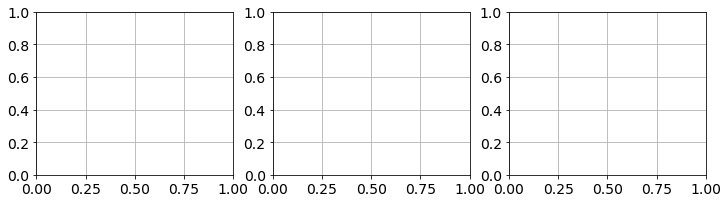

In [34]:
f = lambda x,t : 0 

fig, [ax1, ax2, ax3] = plt.subplots(1,3,figsize=(12, 3))

# EP
x, t, U = imex(European_put,f, M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    ax1.plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
    ax1.legend()

# BS
x, t, U = imex(butterfly_spread,f, M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    ax2.plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))

# BC
x, t, U = imex(binary_call,f, M=40, N=1700, T=0.5, R = 5)
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    ax3.plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))

ax1.set_ylabel('u(x,t)')
ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax3.set_xlabel('x')
ax1.set_title('European put')
ax2.set_title('Butterfly spread')
ax3.set_title('Binary call')

#plt.savefig('experiment_nonlin.pdf')
#files.download('experiment_nonlin.pdf')

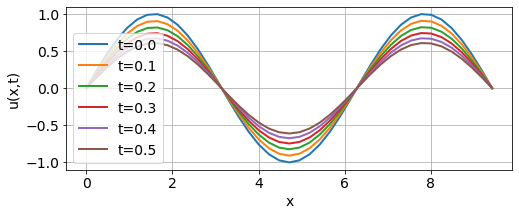

In [ ]:
x, t, U = imex(u_initial_nonlin,RHS_nonlinear, M=40, N=1700, T=0.5, R = 3*np.pi)
# Plot for certain times
figure, ax = plt.subplots(1,1, figsize=(8, 3))
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
  n = int(tn/k)
  tn = n*k
  plt.plot(x,U[:,n],'-',label='t={:.1f}'.format(tn))
plt.xlabel('x',fontsize = 14)
plt.ylabel('u(x,t)',fontsize = 14)
plt.legend()

#plt.savefig('trial_nonlin.pdf')
#files.download('trial_nonlin.pdf')

## Space and Time Error in IMEX

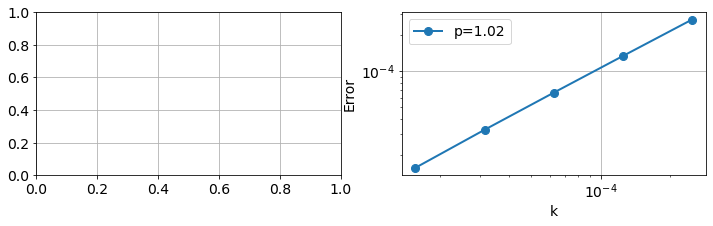

In [ ]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 3))

def convergence_t_nonlin(solver=forward_euler, RHS=0): 
    P = 5
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 400
    for p in range(P):
        x, t, U = solver(u_initial_nonlin, RHS, M=40, N=N, T=0.1, R=3*np.pi)
        Eh = U_ref[:,-1] - U[:,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

x, t, U_ref = imex(u_initial_nonlin, RHS_nonlinear, M=40, N=100000, T=0.1, R=3*np.pi)
T, E, p = convergence_t_nonlin(imex, RHS_nonlinear)
ax2.loglog(T,E,'o-', label='p={:.2f}'.format(p))
ax2.set_xlabel('k')
ax2.set_ylabel('Error')
ax2.legend();


#plt.savefig('imex_error.pdf')
#files.download('imex_error.pdf')

## An attempt to solve 2c

In [ ]:
# f should be a vector function of U^n, U^(n+1) 
# Need a matrix for the jacobian

In [2]:
def vector_f(x, y, RHS, R, M, T, N):
    # x spiller rollen til U^(n+1)= [U_0, U_1, ..., U_(M-1), U_M]
    # y spiller rollen tl U^(n)
    # RHS  vector that contains [f_0, f_1, ..., f_M]
    # R simulates infinity
    # M number of gridpoints in x
    # T endtime
    # N no. of timesteps
    h = R / M
    k = T / N
    dim = np.size(x) #M+1
    # size(x) bør være lik np.size(y) = M+1, vi vil utelate randpunktene,
    # siden ligningene er kun for m=1,..., M-1
    #
    # Returnerer en vektor med dimensjon M-1
    f = np.zeros(dim-2)
    for i in range(1, dim-1): #1, ..., M-1
        arg = x[i-1] - 2*x[i] + x[i+1]
        f[i-1] = x[i] - y[i] - 0.5* i**2 * phi(arg/(h**2)) * k * arg - k*RHS[i]
    return f

In [1]:
def Jacobi_f(U, R, M, T, N):
    h = R/M; k = T/N
    dim = np.size(U)
    Jacobi_matrix = np.zeros(shape=(dim-2, dim-2))

    for i in range(dim-2):
        mid = (U[i]-2*U[i+1]+U[i+2])
        arg = phi_derivative(mid/(h**2)) * mid/(h**2) + phi(mid/(h**2))
        if i-1 < 0:
            pass
        else:
            Jacobi_matrix[i][i-1] = - (i+1)**2 / 2 * arg * k

        if i+2 > dim-2:
            pass
        else:
            Jacobi_matrix[i][i+1] = - (i+1)**2 / 2 * arg * k

        Jacobi_matrix[i][i] = 1 + (i+1)**2 * arg * k
    return Jacobi_matrix 

In [32]:
def Newtons_method(f,x,y, RHS, R, M, T, N):
  """
  Input:
      RHS(vector) [f_0, f_1, .., f_M]
  """
  z = x
  h = R/M; k = T/N
  for n in range(50):
    Jacobi_mat = Jacobi_f(z, R, M, T, N)
    func = f(z, y, RHS, R, M, T, N)
    z[1:-1] = z[1:-1] - np.linalg.inv(Jacobi_mat).dot(func)
  return z[1:-1] 

def alt_Newtons_method(f,x,y,RHS,R,M,T,N):
  """
  Input:
      RHS(vector) [f_0, f_1, .., f_M]
  """
  z = x
  for n in range(20):
    Jacobi_mat = Jacobi_f(z, R, M, T, N)
    func = f(z, y, RHS, R, M, T, N)
    q = np.linalg.solve(Jacobi_mat, -func)
    z[1:-1] += q
  return z[1:-1] 

In [30]:
def nonlin_backward_euler(g, f, RHS, M=10, N=100, T=0.5, R=5):
    # Solve the BS equation
    # with boundary conditions u(0,t)=u(0,0)e^{-ct}
    # and u(R,t) = u(R,0) if Dirichlet,
    # with initial values u(x,0)=g(x)
    # over the time interval from 0 to T
    # and space interval 0 to R ("infinity").
    # Input:
    #       g: function with the initial values, European put by default
    #       f: the whole nonlinear BS transferred to the LHS of PDE
    #       RHS: RHS of equation
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of time integration
    #       R: considered infinity in x-direction
    # Output:
    #       x, t: the gridpoints in the x- and t- directions
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values

    # Currently only Dirichlet
    P = M - 1

    e = np.ones(N+1)
    U[0, :] = g(x[0])*e
    U[-1, :] = g(x[-1])*e

    for n in range(N):
      Y = U[:, n]
      Y[0] = U[0, n+1]; Y[-1] = U[-1, n+1];
      U[1:-1, n+1] = Newtons_method(f, Y, U[:, n], RHS(x, t[n+1]), R, M, T, N)

    return x, t, U

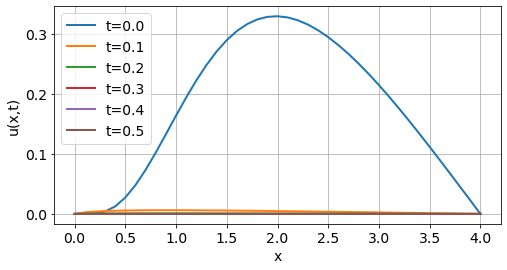

In [33]:
# Plot nonlinear BE
RHS = lambda x,t: np.zeros(np.size(x))
x, t, U = nonlin_backward_euler(butterfly_spread,vector_f, RHS, M=40, N=100, T=0.5, R = 4)
plot_solution(x,t,U)
plt.show()


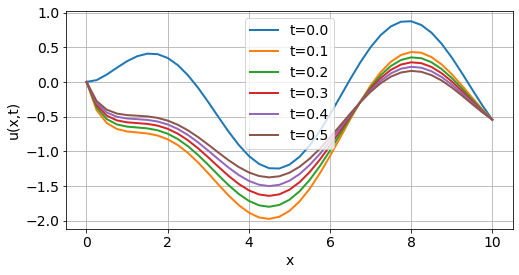

In [ ]:
#Plot nonlinear BE
RHS = lambda x,t: np.zeros(np.size(x))
x, t, U = nonlin_backward_euler(u_initial_nonlin,vector_f, RHS_nonlinear, M=40, N=1500, T=0.5, R = 10)
plot_solution(x,t,U)
plt.show()


### Error analysis BE nonlinear

In [ ]:
"""
H, E, p = convergence_x(u_exact, u_initial, RHS_nonlinear, T=0.1, R=3*np.pi, Neumann=False, solver=nonlin_backward_euler)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.legend()
"""

"\nH, E, p = convergence_x(u_exact, u_initial, RHS_nonlinear, T=0.1, R=3*np.pi, Neumann=False, solver=nonlin_backward_euler)\nplt.loglog(H,E,'o-', label='p={:.2f}'.format(p))\nplt.legend()\n"